This workbook is created based on the presentation at the Data Incubator [here](https://github.com/thedataincubator/DS30_4/blob/master/RLtalk.ipynb). I modify the workbook to:
- Incorporate a more object-oriented approach
- Draw more similarity between Multi Armed Bandits and A/B test by simulating the reward based a binomial distribution (instead of normal)

In [8]:
## Source 
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

Let's create a base class for our Multi-armed bandit.

In [92]:
class Bandit(ABC):
    def __init__(self, arm_values):
        self.arm_values = arm_values
        self.est_values = np.zeros(len(arm_values))
        self.K = np.zeros(len(arm_values))
        self.numArms = len(arm_values)
        
    def get_reward(self, action):
        reward = np.random.binomial(100, self.arm_values[action])
        return reward

    @abstractmethod
    def choose_strategy(self):
        pass
    
    @abstractmethod
    def update(self, action, reward):
        pass

For this approach, we maintain an estimation of reward for each arm. We are inclined to choose the arm with the highest estimated reward, but with probability $\epsilon$, we pick an arm randomly.

In [94]:
# Bandit using Greedy Epsilon approach
class Bandit_Epsilon(Bandit):
    def __init__(self, arm_values, epsilon):
        super(Bandit_Epsilon, self).__init__(arm_values)
        self.epsilon = epsilon 
    
    def choose_strategy(self):
        rand_num = np.random.random()
        if self.epsilon > rand_num:
            return np.random.randint(10)
        else:
            # with probability of epsilon we pick the estimated max
            return np.argmax(self.est_values)
    
    def update(self, action, reward):
        self.K[action]+= 1
        alpha = 1./ self.K[action]
        
        # running average of reward
        self.est_values[action] += alpha * (reward - self.est_values[action])

In [122]:
# Bandit using Randomized Probability matching
class Bandit_RPM(Bandit):
    def __init__(self, arm_values):
        super(Bandit_RPM, self).__init__(arm_values)
        self.parms = [[1., 1.] for i in arm_values]
        
    def choose_strategy(self):
        # Thompson sampling to choose action
        # Not choosing the max posterior BUT
        # Sample from each posterior and choose the max of the sample
        # see more at: https://agrawal.wikischolars.columbia.edu/file/view/Lecture+4.pdf
        samples = np.zeros(self.numArms)
        for key in range(self.numArms):
            samples[key] = np.random.beta(self.parms[key][0], self.parms[key][1])
        
        return np.argmax(samples)

    def update(self, action, reward):
        a, b = self.parms[action]
        # Posterior update of beta
        self.parms[action] = (a + reward, b + 100 - reward)      

Let's start with our simulation. The arm_values are uniform random.

In [101]:
def experiment(bandit, Npulls):
    history = []
    for i in range(Npulls):
        action = bandit.choose_strategy()
        R = bandit.get_reward(action)
        bandit.update(action, R)
        history.append(R)
    return np.array(history)

In [127]:
Nexp = 100
Npulls = 3000
avg_outcome_eps0p0 = np.zeros(Npulls)
avg_outcome_eps0p01 = np.zeros(Npulls)
avg_outcome_eps0p1 = np.zeros(Npulls)
avg_outcome_eps0p3 = np.zeros(Npulls)
avg_outcome_rpm = np.zeros(Npulls)

np.random.seed(42)

for i in range(Nexp):
    arm_values = np.random.uniform(0.01, 0.1, 10)
    bandit = Bandit_Epsilon(arm_values, 0.0)
    avg_outcome_eps0p0 += experiment(bandit,Npulls)
    
    bandit = Bandit_Epsilon(arm_values, 0.01)
    avg_outcome_eps0p01 += experiment(bandit,Npulls)
    
    bandit = Bandit_Epsilon(arm_values, 0.1)
    avg_outcome_eps0p1 += experiment(bandit,Npulls)
    
    bandit = Bandit_Epsilon(arm_values, 0.3)
    avg_outcome_eps0p3 += experiment(bandit,Npulls)
    
    bandit = Bandit_RPM(arm_values)
    avg_outcome_rpm += experiment(bandit,Npulls)

avg_outcome_eps0p0 /= np.float(Nexp)
avg_outcome_eps0p01 /= np.float(Nexp)
avg_outcome_eps0p1 /= np.float(Nexp)
avg_outcome_eps0p3 /= np.float(Nexp)
avg_outcome_rpm /= np.float(Nexp)

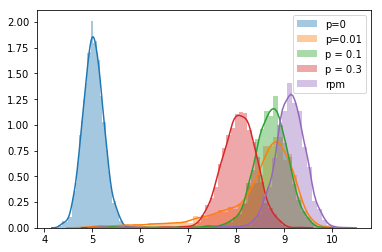

In [128]:
sns.distplot(avg_outcome_eps0p0, label = 'p=0')
sns.distplot(avg_outcome_eps0p01, label = 'p=0.01')
sns.distplot(avg_outcome_eps0p1, label = 'p = 0.1')
sns.distplot(avg_outcome_eps0p3, label = 'p = 0.3')
sns.distplot(avg_outcome_rpm, label = 'rpm')
plt.legend()

In [130]:
print(np.percentile(avg_outcome_eps0p0, 0.01))
print(np.percentile(avg_outcome_eps0p01, 0.01))
print(np.percentile(avg_outcome_eps0p1, 0.01))
print(np.percentile(avg_outcome_eps0p3, 0.01))
print(np.percentile(avg_outcome_rpm, 0.01))

4.295998
4.828997
5.160983
5.175938
5.135988


There appears to be no monotonic relationship between $\epsilon$ and the performance of the algorithm: when p = 0.3, the performance is not better than when p = 0.1 or p = 0.01. Overall, the Thompson sampling method has the best performance.